<a href="https://colab.research.google.com/github/kapilthakre/COVID-19-Analysis-and-Prediction/blob/master/COVID_19_Analysis_%26_Prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***NOTE***: *Please open this notebook In Google Colab to see Beautiful Interactive Graphs.*

# COVID-19 India: Analysis & Prediciton

## What is COVID-19?

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus.

Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment.  Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.

### How its Spread

The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes, so it’s important that you also practice respiratory etiquette (for example, by coughing into a flexed elbow).


### Prevention

The best way to **prevent and slow down transmission** is be well informed about the COVID-19 virus, the disease it causes and how it spreads. Protect yourself and others from infection by washing your hands or using an alcohol based rub frequently and not touching your face. and always ware face mask.

### *In this notebook, the main focus is to analyze the spread trend of this virus In India and all over the world.*

Tasks to be performed:

* Exploring and Analysing the world wide data
* Analysing the present condition in India
* Is this trend similar to  US/Italy/China?
* Prediciting the India COVID-19 cases using Prophet

# Getting Started
Let's import some libraries we will need:

In [108]:
# importing the required libraries
import numpy as np
import pandas as pd
from datetime import timedelta

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

# Reading the dataset

In [109]:
df_clean_cmlt = pd.read_csv('/content/covid_19_global.csv', parse_dates=['Date'])
df_clean_cmlt.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [110]:
df_clean_cmlt.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
47497,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-21,746,14,588,144,Africa
47498,NaN,Yemen,15.552727,48.516388,2020-07-21,1629,456,741,432,Eastern Mediterranean
47499,NaN,Comoros,-11.645500,43.333300,2020-07-21,337,7,319,11,Africa
47500,NaN,Tajikistan,38.861000,71.276100,2020-07-21,6967,57,5683,1227,Europe
47501,NaN,Lesotho,-29.610000,28.233600,2020-07-21,359,6,69,284,Africa


## Pre processing

In [111]:
df = df_clean_cmlt.copy()

# Derived new column
df['Active'] = df_clean_cmlt['Confirmed']-(df_clean_cmlt['Deaths']+df_clean_cmlt['Recovered'])
# df['Mortality rate'] = df_clean_cmlt['Deaths']/df_clean_cmlt['Confirmed']

df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [112]:
# grouped by day, country

full_grouped = df.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

# new cases ======================================================
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

# renaming columns
temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']
# =================================================================

# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])

# filling na with 0
full_grouped = full_grouped.fillna(0)

# fixing data types
cols = ['New cases', 'New deaths', 'New recovered']
full_grouped[cols] = full_grouped[cols].astype('int')

full_grouped['New cases'] = full_grouped['New cases'].apply(lambda x: 0 if x<0 else x)

df_global = full_grouped[['Date','Country/Region','Confirmed','Deaths','Recovered','Active','New cases']]

In [113]:
df_global.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases
0,2020-01-22,Afghanistan,0,0,0,0,0
1,2020-01-22,Albania,0,0,0,0,0
2,2020-01-22,Algeria,0,0,0,0,0
3,2020-01-22,Andorra,0,0,0,0,0
4,2020-01-22,Angola,0,0,0,0,0


# Analysing COVID-19 Cases in World

### Current Status

In [114]:
#latest Data By date
latest_data = df_global[df_global['Date']==max(df_global['Date'])]

In [115]:
# melt into longer format
tm = latest_data.melt(id_vars="Date", value_vars=['Confirmed','Active', 'Deaths', 'Recovered'])
# plot
fig_1 = px.treemap(tm, path=["variable"], values="value", height=300, width=1500,title='Latest stats')
fig_1.data[0].textinfo = 'label+text+value'
print("Date : 21 Jul, 2020")
fig_1.show()

Date : 21 Jul, 2020


### Number of cases per country/region

In [116]:
temp = latest_data.groupby('Country/Region')['Confirmed','Active','Recovered','Deaths','New cases'].sum()
temp = temp.sort_values(by='Confirmed',ascending=False).reset_index()
temp.style.background_gradient(cmap='Blues')

,Country/Region,Confirmed,Active,Recovered,Deaths,New cases
0,US,3899211,2575198,1182018,141995,64534
1,Brazil,2159654,522828,1555339,81487,41008
2,India,1193078,411296,753050,28732,37740
3,Russia,782040,208082,561397,12561,5828
4,South Africa,381798,168286,208144,5368,8170
5,Peru,362087,99762,248746,13579,8497
6,Mexico,356255,48448,267407,40400,6859
7,Chile,334683,19190,306816,8677,3753
8,United Kingdom,297389,250468,1414,45507,445
9,Iran,278827,21842,242351,14634,2625


## How the Coronavirus cases are rising?

In [117]:
#Daily increase
world_daily_increase = df_global.groupby('Date')['Confirmed','Active','New cases','Deaths', 'Recovered'].sum().reset_index()

In [118]:
# Rise of COVID-19 cases in world
fig = go.Figure()
fig.add_trace(go.Scatter(x=world_daily_increase['Date'], y = world_daily_increase['Confirmed'], mode='lines+markers',name='Confirmed'))
fig.add_trace(go.Scatter(x=world_daily_increase['Date'], y = world_daily_increase['Deaths'], mode='lines+markers',name='Deaths'))
fig.add_trace(go.Scatter(x=world_daily_increase['Date'], y = world_daily_increase['Recovered'], mode='lines+markers',name='Recovered'))
fig.add_trace(go.Scatter(x=world_daily_increase['Date'], y = world_daily_increase['Active'], mode='lines+markers',name='Active'))

fig.update_layout(title_text='Trend of Coronavirus Cases in World (Cumulative cases)',plot_bgcolor='rgb(230, 230, 230)')
fig.show()

### New COVID-19 cases reported daily in World

In [119]:
# New COVID-19 cases reported daily in World
fig = px.bar(world_daily_increase, x="Date", y="New cases", height=600)
fig.update_layout(title_text='Coronavirus Cases in World on daily basis',plot_bgcolor='rgb(230, 230, 230)')

fig.show()

## Top 10 Countries (Confirmed,Deaths, Recovered)

In [120]:
latest_data_byCountry = latest_data.groupby('Country/Region')['Confirmed','Active','New cases','Deaths', 'Recovered'].sum().reset_index()

In [121]:
# Top 10 Country with the most confirmed cases
top10_country_cnf = latest_data_byCountry[['Country/Region','Confirmed']].sort_values(by='Confirmed',ascending=False).reset_index(drop=True).head(10)

# Top 10 Country with the most recovered cases
top10_country_rec = latest_data_byCountry[['Country/Region','Recovered']].sort_values(by='Recovered',ascending=False).reset_index(drop=True).head(10)

# Top 10 Country with the most deaths cases
top10_country_deaths = latest_data_byCountry[['Country/Region','Deaths']].sort_values(by='Deaths',ascending=False).reset_index(drop=True).head(10)

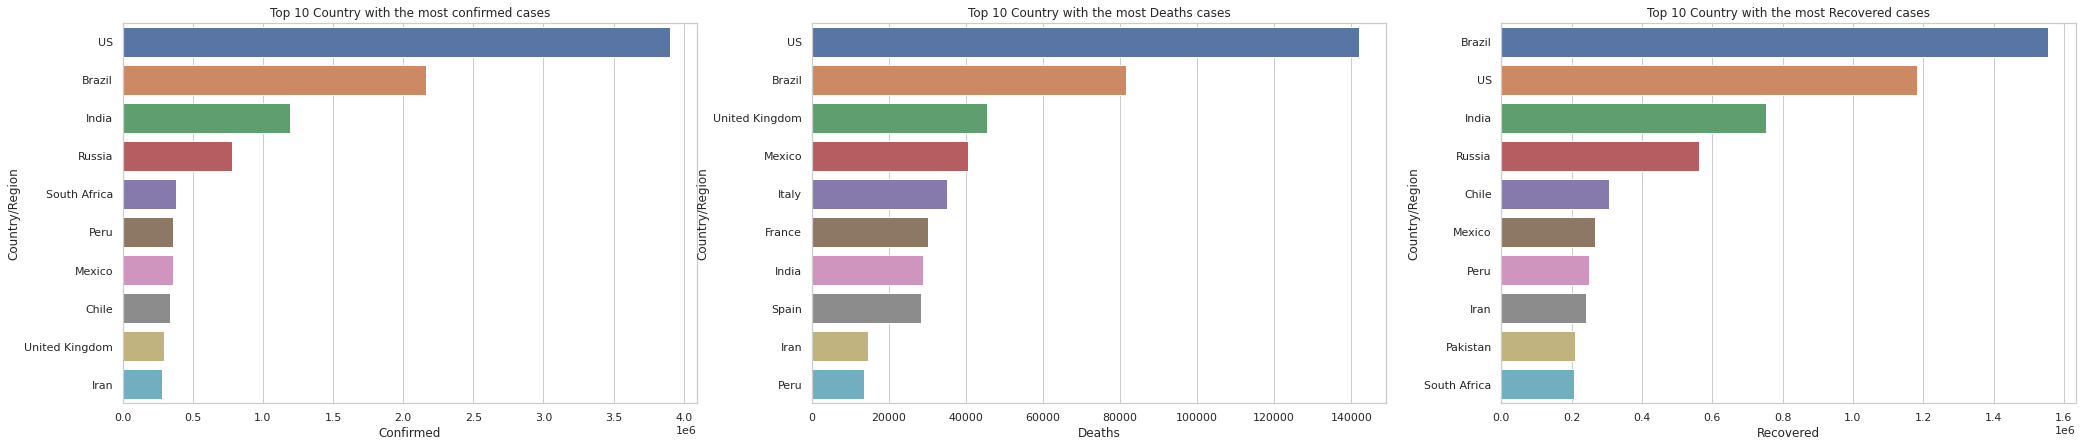

In [122]:
plt.figure(figsize=[35,7])

plt.subplot(1,3,1)
sns.barplot(y=top10_country_cnf['Country/Region'],x=top10_country_cnf['Confirmed']).set_title("Top 10 Country with the most confirmed cases")

plt.subplot(1,3,2)
sns.barplot(y=top10_country_deaths['Country/Region'],x=top10_country_deaths['Deaths']).set_title("Top 10 Country with the most Deaths cases")

plt.subplot(1,3,3)
sns.barplot(y=top10_country_rec['Country/Region'],x=top10_country_rec['Recovered']).set_title("Top 10 Country with the most Recovered cases")

plt.show()

# Trend Comparasion of Different Contries

In [123]:
# Country wise data
us_data = df_global[df_global['Country/Region']=='US'].reset_index(drop=True)
russia_data = df_global[df_global['Country/Region']=='Russia'].reset_index(drop=True)
brazil_data = df_global[df_global['Country/Region']=='Brazil'].reset_index(drop=True)
unitedkingdom_data = df_global[df_global['Country/Region']=='United Kingdom'].reset_index(drop=True)
china_data = df_global[df_global['Country/Region']=='China'].reset_index(drop=True)
italy_data = df_global[df_global['Country/Region']=='Italy'].reset_index(drop=True)
india_data = df_global[df_global['Country/Region']=='India'].reset_index(drop=True)

In [124]:
fig_us = px.bar(us_data, x='Date', y='Confirmed', title='Confirmed Cases in US', color='Confirmed',height=500)
fig_china = px.bar(china_data, x='Date', y='Confirmed', title='Confirmed Cases in China', color='Confirmed',height=500)
fig_russia = px.bar(russia_data, x='Date', y='Confirmed', title='Confirmed Cases in Russia', color='Confirmed',height=500)
fig_italy = px.bar(italy_data, x='Date', y='Confirmed', title='Confirmed Cases in Italy', color='Confirmed',height=500)
fig_uk = px.bar(unitedkingdom_data, x='Date', y='Confirmed', title='Confirmed Cases in United Kingdom', color='Confirmed',height=500)
fig_brazil = px.bar(brazil_data, x='Date', y='Confirmed', title='Confirmed Cases in Brazil', color='Confirmed',height=500)
fig_india = px.bar(india_data, x='Date', y='Confirmed', title='Confirmed Cases in India', color='Confirmed',height=500)

fig_us.show()
fig_russia.show()
fig_italy.show()

In [125]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{}, {}]],
    subplot_titles=("United Kingdom","Brazil", "China","India"))

fig.add_trace(go.Bar(x=unitedkingdom_data['Date'], y=unitedkingdom_data['Confirmed'],marker=dict(color=unitedkingdom_data['Confirmed'], coloraxis="coloraxis")),1, 1)
fig.add_trace(go.Bar(x=brazil_data['Date'], y=brazil_data['Confirmed'],marker=dict(color=brazil_data['Confirmed'], coloraxis="coloraxis")),1, 2)
fig.add_trace(go.Bar(x=china_data['Date'], y=china_data['Confirmed'],marker=dict(color=china_data['Confirmed'], coloraxis="coloraxis")),2, 1)
fig.add_trace(go.Bar(x=india_data['Date'], y=india_data['Confirmed'],marker=dict(color=india_data['Confirmed'], coloraxis="coloraxis")),2, 2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="Total Confirmed cases(Cumulative) Trend")
fig.update_layout(plot_bgcolor='rgb(230, 230, 230)')
fig.show()

# Analysing the present condition in India

In [126]:
# Reading the Dataset
df_india = pd.read_csv('/content/covid_19_india.csv')

# converting string date time column to pandas date time
df_india['Date'] = pd.to_datetime(df_india['Date'],dayfirst=True)

# replace '#' with ''
df_india['State/UnionTerritory'] = df_india['State/UnionTerritory'].str.replace('#', "")

# rename the column
df_india = df_india.rename({'State/UnionTerritory':'State/UT','Cured':'Recovered'},axis=1)

# rearange columns
df_india = df_india[['Date','State/UT','Confirmed','Recovered','Deaths']]

# derived new column such as active,mortlity rate, recovery rate
df_india['Active'] = df_india['Confirmed'] - (df_india['Deaths']+df_india['Recovered'])
df_india['Mortality rate'] = df_india['Deaths']/df_india['Confirmed']
df_india['Recovery rate'] = df_india['Recovered']/df_india['Confirmed']

In [127]:
# Final Data
df_india.head()

,Date,State/UT,Confirmed,Recovered,Deaths,Active,Mortality rate,Recovery rate
0,2020-01-30,Kerala,1,0,0,1,0.0,0.0
1,2020-01-31,Kerala,1,0,0,1,0.0,0.0
2,2020-02-01,Kerala,2,0,0,2,0.0,0.0
3,2020-02-02,Kerala,3,0,0,3,0.0,0.0
4,2020-02-03,Kerala,3,0,0,3,0.0,0.0


# Current Status In India

In [128]:
pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.9.0)


In [129]:
# latest data by date
latest_data_india = df_india[df_india['Date']==(max(df_india['Date']))]
latest_data_india_states = latest_data_india.groupby('State/UT')['Confirmed','Active','Recovered','Deaths','Mortality rate','Recovery rate'].sum().reset_index()

print("Date : 21 Jul, 2020")
print("Total number of Confirmed COVID-19 cases across India till date:",latest_data_india['Confirmed'].sum())
print("Total number of Active COVID-19 cases across India till date:",latest_data_india['Active'].sum())
print("Total number of Recovered COVID-19 cases across India till date:",latest_data_india['Recovered'].sum())

# Visualisation
tm = latest_data_india.melt(id_vars="Date", value_vars=['Confirmed','Deaths', 'Recovered'])
fig = px.treemap(tm, path=["variable"], values="value", height=300, width=1400,title='Latest stats', color='variable')
fig.data[0].textinfo = 'label+text+value'

fig.show()

Date : 21 Jul, 2020
Total number of Confirmed COVID-19 cases across India till date: 1155191
Total number of Active COVID-19 cases across India till date: 402529
Total number of Recovered COVID-19 cases across India till date: 724578


## Number of COVID-19 cases across Indian states

In [130]:
temp = latest_data_india_states
temp = temp.sort_values(by='Confirmed',ascending=False).reset_index(drop=True)

temp.style\
    .background_gradient(cmap="Blues", subset=['Confirmed', 'Active'])\
    .background_gradient(cmap="Greens", subset=['Recovered', 'Recovery rate'])\
    .background_gradient(cmap="Reds", subset=['Deaths', 'Mortality rate'])

,State/UT,Confirmed,Active,Recovered,Deaths,Mortality rate,Recovery rate
0,Maharashtra,318695,131636,175029,12030,0.037748,0.549205
1,Tamil Nadu,175678,51351,121776,2551,0.014521,0.693177
2,Delhi,123747,15166,104918,3663,0.029601,0.847843
3,Karnataka,67420,42222,23795,1403,0.020810,0.352937
4,Andhra Pradesh,53724,28800,24228,696,0.012955,0.450972
5,Uttar Pradesh,51160,19137,30831,1192,0.023299,0.602639
6,Gujarat,49353,11513,35678,2162,0.043807,0.722915
7,Telangana,46274,11529,34323,422,0.009120,0.741734
8,West Bengal,44769,17204,26418,1147,0.025620,0.590096
9,Rajasthan,30390,7627,22195,568,0.018690,0.730339


# How the Coronavirus cases are rising In India?

In [131]:
# Group by date
india_daily_increase = df_india.groupby('Date')['Confirmed', 'Active', 'Deaths', 'Recovered'].sum().reset_index()

In [132]:
# Rise of COVID-19 cases in India
fig = go.Figure()
fig.add_trace(go.Scatter(x=india_daily_increase['Date'], y = india_daily_increase['Confirmed'], mode='lines+markers',name='Confirmed'))
fig.add_trace(go.Scatter(x=india_daily_increase['Date'], y = india_daily_increase['Deaths'], mode='lines+markers',name='Deaths'))
fig.add_trace(go.Scatter(x=india_daily_increase['Date'], y = india_daily_increase['Recovered'], mode='lines+markers',name='Recovered'))
fig.add_trace(go.Scatter(x=india_daily_increase['Date'], y = india_daily_increase['Active'], mode='lines+markers',name='Active'))
fig.update_layout(title_text='Trend of Coronavirus Cases in India (Cumulative cases)',plot_bgcolor='rgb(230, 230, 230)')

# Trend of Coronavirus Confirme Cases in India
fig1 = px.bar(india_daily_increase, x="Date", y="Confirmed",title='Trend of Coronavirus Confirme Cases in India',color='Confirmed',height=500)
fig1.update_layout(barmode='overlay', title='Coronavirus Cases in India on daily basis')

# India Daily new Cases
fig2 = px.bar(india_data, x="Date", y="New cases",title='Coronavirus Cases in India on daily basis', height=500)
fig2.update_layout(barmode='overlay', title='Coronavirus Cases in India on daily basis',
                 annotations=[dict(x='2020-03-23', y=106, xref="x", yref="y", text="First Lockdown (23rd March)", showarrow=True, arrowhead=1, ax=-50, ay=-200),
                              dict(x='2020-04-15', y=600, xref="x", yref="y", text="Second Lockdown (15th April)", showarrow=True, arrowhead=1, ax=-70, ay=-100),
                              dict(x='2020-05-04', y=3932, xref="x", yref="y", text="Third Lockdown (4th May)", showarrow=True, arrowhead=1, ax=-200, ay=0)])
fig.show()
fig1.show()
fig2.show()

## Top 10 States In India (Confirmed,Deaths, Recovered, Mortality Rate..)

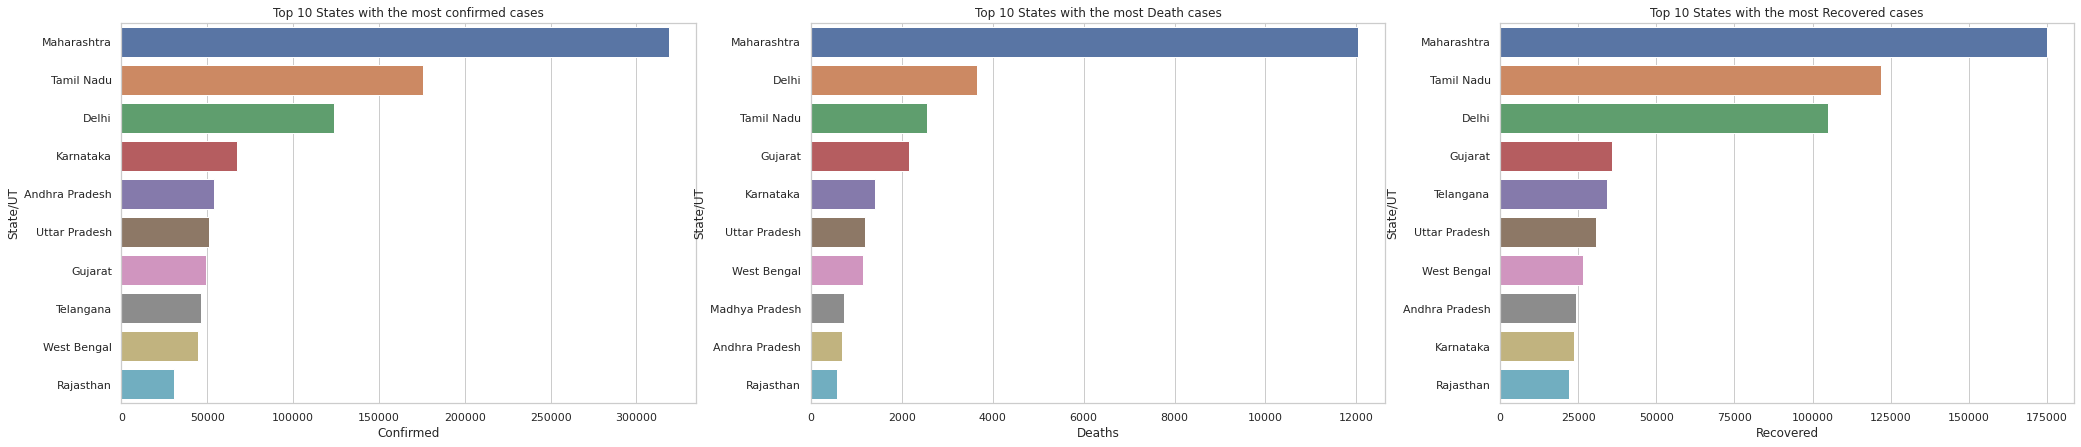

In [133]:
plt.figure(figsize=[35,7])

plt.subplot(1,3,1)
sns.barplot(x='Confirmed',y='State/UT',data=latest_data_india_states.sort_values(by='Confirmed',ascending=False).head(10)).set_title("Top 10 States with the most confirmed cases")

plt.subplot(1,3,2)
sns.barplot(x='Deaths',y='State/UT',data=latest_data_india_states.sort_values(by='Deaths',ascending=False).head(10)).set_title("Top 10 States with the most Death cases")

plt.subplot(1,3,3)
sns.barplot(x='Recovered',y='State/UT',data=latest_data_india_states.sort_values(by='Recovered',ascending=False).head(10)).set_title("Top 10 States with the most Recovered cases")
plt.show()

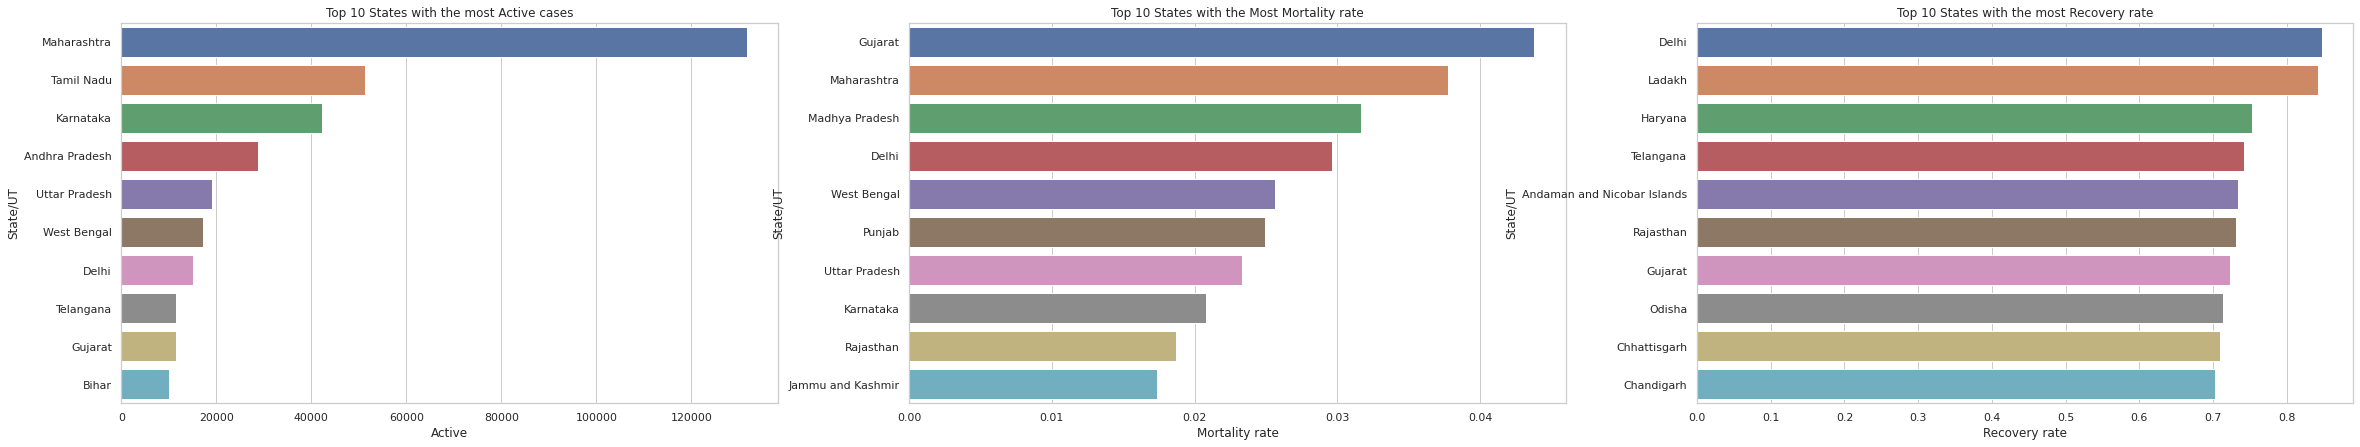

In [134]:
plt.figure(figsize=[40,7])

plt.subplot(1,3,1)
sns.barplot(x='Active',y='State/UT',data=latest_data_india_states.sort_values(by='Active',ascending=False).head(10)).set_title("Top 10 States with the most Active cases")

plt.subplot(1,3,2)
sns.barplot(x='Mortality rate',y='State/UT',data=latest_data_india_states.sort_values(by='Mortality rate',ascending=False).head(10)).set_title("Top 10 States with the Most Mortality rate")

plt.subplot(1,3,3)
sns.barplot(x='Recovery rate',y='State/UT',data=latest_data_india_states.sort_values(by='Recovery rate',ascending=False).head(10)).set_title("Top 10 States with the most Recovery rate")
plt.show()

# Where does India Stands

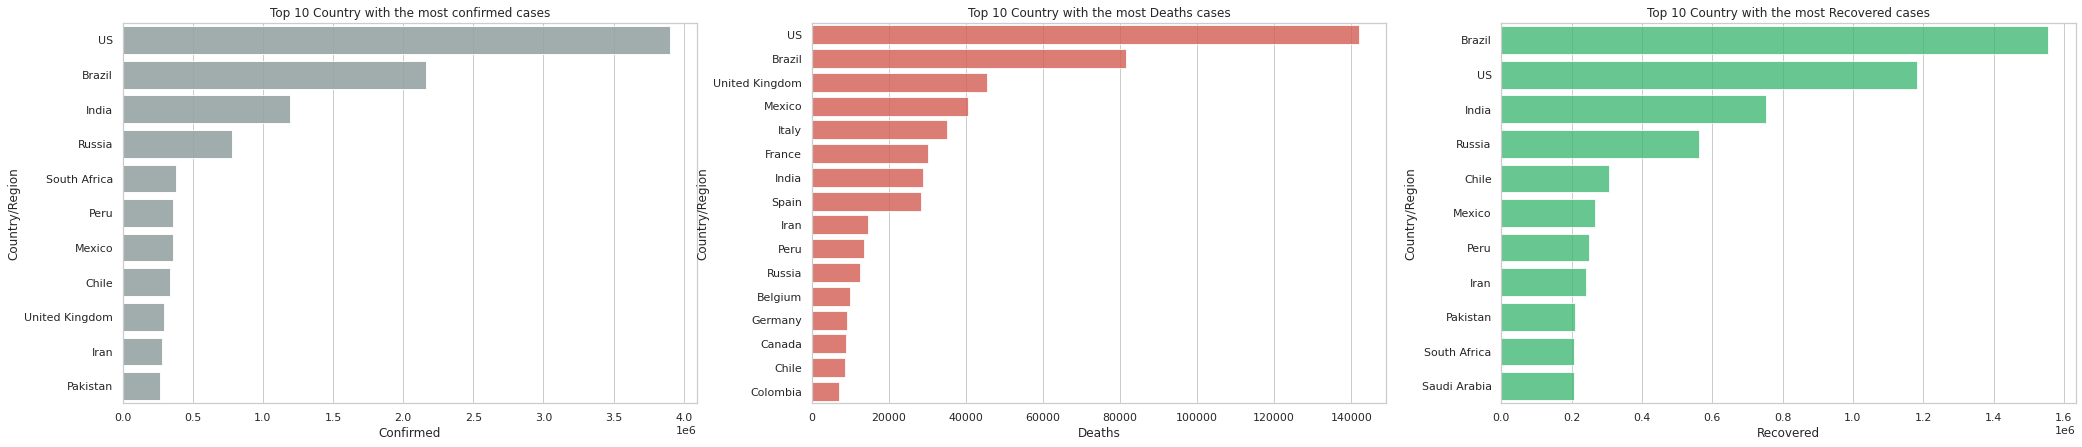

In [135]:
plt.figure(figsize=[35,7])

plt.subplot(1,3,1)
sns.barplot(y='Country/Region',x='Confirmed', data=latest_data_byCountry.sort_values(by='Confirmed',ascending=False).reset_index(drop=True).head(11),
            color="#95a5a6", alpha=0.9).set_title("Top 10 Country with the most confirmed cases")

plt.subplot(1,3,2)
sns.barplot(y='Country/Region',x='Deaths', data=latest_data_byCountry.sort_values(by='Deaths',ascending=False).reset_index(drop=True).head(16),
            color="#e74c3c", alpha=0.8).set_title("Top 10 Country with the most Deaths cases")

plt.subplot(1,3,3)
sns.barplot(y='Country/Region',x='Recovered', data=latest_data_byCountry.sort_values(by='Recovered',ascending=False).reset_index(drop=True).head(11),
            color="#2ecc71", alpha=0.8).set_title("Top 10 Country with the most Recovered cases")

plt.show()

# Is the trend similar to Italy/ US/ China?

In [136]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{}, {}]],
    subplot_titles=("Italy","US", "China","India"))

fig.add_trace(go.Bar(x=italy_data['Date'], y=unitedkingdom_data['Confirmed'],marker=dict(color=unitedkingdom_data['Confirmed'], coloraxis="coloraxis")),1, 1)
fig.add_trace(go.Bar(x=us_data['Date'], y=brazil_data['Confirmed'],marker=dict(color=brazil_data['Confirmed'], coloraxis="coloraxis")),1, 2)
fig.add_trace(go.Bar(x=china_data['Date'], y=china_data['Confirmed'],marker=dict(color=china_data['Confirmed'], coloraxis="coloraxis")),2, 1)
fig.add_trace(go.Bar(x=india_data['Date'], y=india_data['Confirmed'],marker=dict(color=india_data['Confirmed'], coloraxis="coloraxis")),2, 2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="Total Confirmed cases(Cumulative) Trend")
fig.update_layout(plot_bgcolor='rgb(230, 230, 230)')
fig.show()

# Forecasting Total Number of Cases In India
Prediction by Prophet Model

In [137]:
from fbprophet import Prophet

In [138]:
confirmed = india_daily_increase.groupby('Date')['Confirmed'].sum().reset_index()
confirmed.columns = ['ds','y']

In [139]:
m = Prophet(interval_width=0.95)
m.fit(confirmed)

# Forcast for next 15 days
future = m.make_future_dataframe(periods=15)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


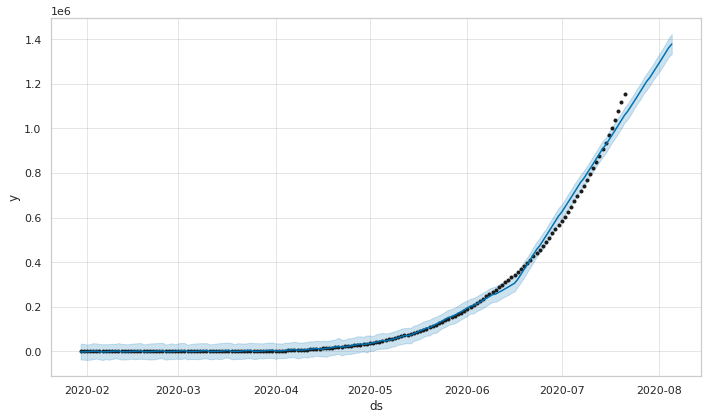

In [140]:
# predicting the future with date, and upper and lower limit of y value
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)
confirmed_forecast_plot = m.plot(forecast)

Prediction for next 15 Days

# Stay home! Stay Safe!